In [2]:
from datetime import datetime
import math
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

In [22]:
candles = pd.read_csv('dataset training USDCAD m15.csv')
candles['time'] = pd.to_datetime(candles['time'])
candles.set_index('time', inplace=True)

In [23]:
#mav
mean = candles['close']
mav1 = mean.rolling(window=5).mean()
mav2 = mean.rolling(window=10).mean()
mav3 = mean.rolling(window=25).mean()

candles['mav1'] = mav1 
candles['mav2'] = mav2 
candles['mav3'] = mav3

In [24]:
#bollinger
mean = candles['close']
mean = mean.rolling(window=10).mean()

std_dev = candles['close']
std_dev = std_dev.rolling(window=30).std()

UBB = mean + (4 * std_dev)
LBB = mean - (4 * std_dev)
DiffBB = UBB - LBB
candles['DiffBB']=DiffBB
y_1 = candles['entry']
del candles["entry"]
print(len(candles))
print(len(y_1))
print(candles)
print(y_1)

51943
51943
                        open     high      low    close  vol      mav1  \
time                                                                     
2020-03-02 00:00:00  1.34345  1.34347  1.34291  1.34311    0       NaN   
2020-03-02 00:15:00  1.34289  1.34330  1.34241  1.34265    0       NaN   
2020-03-02 00:30:00  1.34265  1.34280  1.34186  1.34251    0       NaN   
2020-03-02 00:45:00  1.34251  1.34376  1.34251  1.34367    0       NaN   
2020-03-02 01:00:00  1.34367  1.34369  1.34103  1.34169    0  1.342726   
...                      ...      ...      ...      ...  ...       ...   
2022-03-31 23:00:00  1.25026  1.25026  1.24896  1.24924    0  1.249020   
2022-03-31 23:15:00  1.24923  1.25013  1.24923  1.25006    0  1.249430   
2022-03-31 23:30:00  1.25006  1.25093  1.24990  1.25088    0  1.249936   
2022-03-31 23:45:00  1.25088  1.25092  1.25045  1.25048    0  1.250190   
2022-04-01 00:00:00  1.25011  1.25051  1.24938  1.25039    0  1.250210   

                         

In [25]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
candles_norm = scaler.fit_transform(candles)

In [26]:
#rimozione nan def
y_1= y_1[30:]
candles_norm = candles_norm[30:]
print(len(candles_norm))
print(len(y_1))

51913
51913


In [27]:
#dataset building
x_candles = []
x_time = []
y = []
step_back = 48
print('Penis')

for i in range(len(candles_norm) - step_back):
    example_candles = []
    example_time = []
    
    for o in range(0, step_back):
        example_candles.append(candles_norm[i + o])
        t = candles.iloc[30 + i + o].name
        example_time.append([t.hour / 24, t.weekday() / 7])
    
    x_candles.append(example_candles)
    x_time.append(example_time)
    y.append(y_1[i+step_back])

Penis


In [43]:
split_point = int(len(x_candles) * 0.8)
y=np.array(y)

x_train_candles = np.asarray(x_candles[:split_point], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point], dtype=np.float32)


y_train=np.asarray(y[:split_point], dtype=np.float32)
print(len(x_candles))
print(len(y))
x_test_candles = np.asarray(x_candles[split_point:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point:], dtype=np.float32)
y_test=np.asarray(y[split_point:], dtype=np.float32)

last_point= (int(len(x_test_candles))-1)
x_trial_candles =x_test_candles[last_point:]
x_trial_time = x_test_time[last_point:]
print(x_test_candles.shape)
print(y_test.shape)




51865
51865
(10373, 48, 9)
(10373,)


In [44]:
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D()(conv_1)
    
    conv_2 = keras.layers.Conv1D(
        filters=64,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D()(conv_2)
    
    lstm_1 = keras.layers.LSTM(units=64, return_sequences=True)(average_2)
    lstm_2 = keras.layers.LSTM(units=64)(lstm_1)
    
    return lstm_2


input_candles = keras.Input(shape=(x_train_candles.shape[1], x_train_candles.shape[2]), name='Candles')
input_time = keras.Input(shape=(x_train_time.shape[1], x_train_time.shape[2]), name='Time')

conv_1 = get_conv_lstm_block(input_candles, kernel_size_1=3, kernel_size_2=3)
conv_2 = get_conv_lstm_block(input_candles, kernel_size_1=7, kernel_size_2=7)
conv_3 = get_conv_lstm_block(input_candles, kernel_size_1=13, kernel_size_2=13)

lstm_time_1 = keras.layers.LSTM(units=8, return_sequences=True)(input_time)
lstm_time_2 = keras.layers.LSTM(units=8)(lstm_time_1)

conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, lstm_time_2])

dense_1 = keras.layers.Dense(units=128, activation=keras.activations.sigmoid)(conc)
dense_2 = keras.layers.Dense(units=128, activation=keras.activations.sigmoid)(dense_1)

output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_2)

model = keras.Model(inputs=[input_candles, input_time], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_absolute_error)

model.summary()
keras.utils.plot_model(model, "conv_lstm_net.png", show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 48, 32)       896         ['Candles[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 48, 32)       2048        ['Candles[0][0]']                
                                                                                                  
 conv1d_22 (Conv1D)             (None, 48, 32)       3776        ['Candles[0][0]']                
                                                                                            

In [45]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights2/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    [x_train_candles, x_train_time],
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(
        [x_test_candles, x_test_time],
        y_test
    ),
    callbacks=model_checkpoint_callback
)

model.load_weights('weights2/weights')

Epoch 1/25
1297/1297 [==============================] - 118s 73ms/step - loss: 0.0523 - val_loss: 0.0192
Epoch 2/25
1297/1297 [==============================] - 222s 171ms/step - loss: 0.0362 - val_loss: 0.0244
Epoch 3/25
1297/1297 [==============================] - 211s 163ms/step - loss: 0.0332 - val_loss: 0.0076
Epoch 4/25
1297/1297 [==============================] - 224s 172ms/step - loss: 0.0318 - val_loss: 0.0150
Epoch 5/25
1297/1297 [==============================] - 204s 157ms/step - loss: 0.0301 - val_loss: 0.0166
Epoch 6/25
1297/1297 [==============================] - 79s 61ms/step - loss: 0.0297 - val_loss: 0.0158
Epoch 7/25
1297/1297 [==============================] - 85s 65ms/step - loss: 0.0306 - val_loss: 0.0095
Epoch 8/25
1297/1297 [==============================] - 99s 76ms/step - loss: 0.0311 - val_loss: 0.0142
Epoch 9/25
1297/1297 [==============================] - 99s 76ms/step - loss: 0.0307 - val_loss: 0.0092
Epoch 10/25
1297/1297 [==============================] 

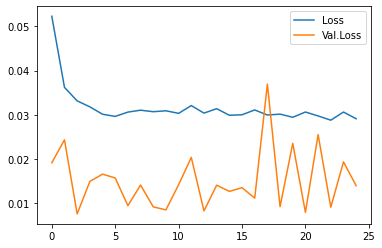

In [46]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [47]:
preds = model.predict([x_test_candles, x_test_time],batch_size=32)

y_test3 = []
preds3 = []
for n in range(len(y_test)):
    print(preds[n])
    y_test3.append(y_test[n])
    preds3.append(preds[n])

[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00

[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00

[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00

[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00

[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00

[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00

[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00

[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00

[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00

[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181767]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00

[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181767]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181755]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]
[-0.00181761]


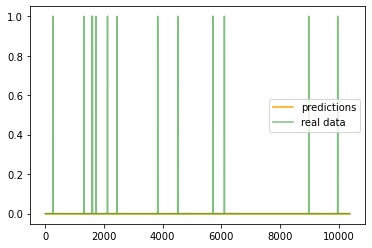

In [48]:
plt.plot(np.asarray(preds), color='orange', label='predictions')
plt.plot(np.asarray(y_test), color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()